## retrieve data from material project

In [1]:
from mp_api.client import MPRester
key="Z7NcMZxFm5LyvsQZk9k7sD8ZgMdQZstr"

with MPRester(key) as mpr:
    data=mpr.materials.summary.search(formula='ABC3',fields=["structure","material_id","nelements","formula_pretty","formula_anonymous","theoretical","is_stable", "volume", "elements","band_gap","formation_energy"])
    

C:\Users\YujuL\anaconda3\envs\Group\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Retrieving SummaryDoc documents: 100%|██████████| 4555/4555 [00:07<00:00, 620.27it/s]


## Feature Engineering

In [2]:
from matminer.featurizers.bandstructure import BranchPointEnergy
from matminer.featurizers.bandstructure import BandFeaturizer
from matminer.featurizers.structure import XRDPowderPattern
from matminer.featurizers.conversions import StrToComposition
from matminer.featurizers.structure import DensityFeatures


import pandas as pd

In [3]:


stable = []
structures = []
band_gaps = []
theory = []
ids = []
formula=[]
for sample in data:
    stable.append(sample.is_stable)
    structures.append(sample.structure)
    band_gaps.append(sample.band_gap)
    theory.append(sample.theoretical)
    ids.append(sample.material_id)
    formula.append(sample.formula_pretty)

perov_df = pd.DataFrame(
    {"material ids": ids,
     "structure": structures,
     "band gaps": band_gaps,
     "theoretical": theory,
     "stable": stable,
     "formula":formula
    })


In [4]:
real_perovs = perov_df[perov_df["theoretical"]==False]
real_perovs["stable"] = real_perovs["stable"].astype(int)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [5]:
real_perovs=real_perovs[real_perovs["band gaps"]>1]

In [6]:
densityf = DensityFeatures()
densityf.feature_labels()

density_df = densityf.featurize_dataframe(real_perovs, "structure")
density_df.head()

DensityFeatures: 100%|██████████| 718/718 [00:43<00:00, 16.68it/s] 


,material ids,structure,band gaps,theoretical,stable,formula,density,vpa,packing fraction
38,mp-27941,"[[0. 0. 2.42839953] Ag, [0. ...",2.3983,False,0,AgClO3,4.138469,15.353181,0.313426
46,mp-1202188,"[[1.7374665 9.27204812 2.98320164] Ag, [ 4.72...",1.8069,False,0,AgIO3,6.370565,14.741301,0.425548
47,mp-27384,"[[ 0.0379544 4.34558533 10.74899408] Ag, [2....",2.4375,False,1,AgIO3,5.999922,15.651939,0.400789
49,mp-552185,"[[ 6.4553912 4.23319424 14.32099189] Ag, [3....",1.8539,False,1,AgNO3,4.509525,12.510450,0.336071
50,mp-638686,"[[6.12095444 3.4227964 3.81339077] Ag, [0.781...",2.0089,False,0,AgNO3,4.532948,12.445803,0.337816


In [7]:
y = density_df["band gaps"].values
X = density_df.drop(["material ids", "structure", "band gaps", "theoretical", "stable","formula"], axis=1)

In [8]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [9]:
models=[]
accuracy=[]

## SVR

In [10]:
from sklearn.svm import SVR

In [11]:
svm = SVR()

param_grid={'kernel':['linear','poly','rbf','sigmoid'],
            'degree':[1,2,3,4,5],
            'gamma':[0.05,0.1,0.2,0.5,0.7,1.2],
            'C':[0.1,0.2,0.3,0.4,1],
            'epsilon':[0.001,0.005,0.03,0.01,1]
           }


In [12]:
##RandomizedSearchCV to find the best parameter

In [13]:
from sklearn.model_selection import RandomizedSearchCV

In [14]:
from sklearn.model_selection import GridSearchCV

# rand_ser = GridSearchCV(estimator=svm,param_grid=param_grid,cv=10,verbose=2,n_jobs=-1)
# rand_ser.fit(X_train,y_train)
# print(f'best parameter:{rand_ser.best_params_}')
# print(f'best score:{rand_ser.best_score_}')

In [15]:
#svm_model=rand_ser.best_estimator_
svm_model=SVR()
svm_model.fit(X_train,y_train)

SVR()

In [16]:
from sklearn.metrics import mean_squared_error,r2_score

In [17]:
y_pred = svm_model.predict(X_test)
testing_accuracy = svm_model.score(X_test, y_test) * 100
models.append('SVR')
accuracy.append(testing_accuracy)
print(f'Accuracy on test data: {testing_accuracy:.1f} %')


Accuracy on test data: 0.3 %


In [18]:
import numpy as np

In [19]:
SVR_MSE=mean_squared_error(y_test,y_pred)
RMSE=np.sqrt(SVR_MSE)
R2=r2_score(y_test,y_pred)
print('RMSE:'+ str(RMSE))
print('R2:'+str(R2))

RMSE:1.297816722619446
R2:0.0029847868477891337


### Random Forest

In [20]:
from sklearn.ensemble import RandomForestRegressor
rf=RandomForestRegressor()

grid_param={'n_estimators':[int(x) for x in np.linspace(start=100,stop=1000,num=3)],
           'max_features':['auto','sqrt'],
           'max_depth':[int(x) for x in np.linspace(start=10,stop=100,num=3)],
            'min_samples_split':[2,5],
            'min_samples_leaf':[1,2],
            'bootstrap':[True]
           }

rand_ser = RandomizedSearchCV(estimator=rf,param_distributions=grid_param,n_iter=10,)
rand_ser.fit(X_train,y_train)

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max

RandomizedSearchCV(estimator=RandomForestRegressor(),
                   param_distributions={'bootstrap': [True],
                                        'max_depth': [10, 55, 100],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2],
                                        'min_samples_split': [2, 5],
                                        'n_estimators': [100, 550, 1000]})

In [21]:
print(f'best parameter:{rand_ser.best_params_}')
print(f'best score:{rand_ser.best_score_}')

best parameter:{'n_estimators': 550, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 55, 'bootstrap': True}
best score:0.4155818339377067


In [22]:
rf_model=rand_ser.best_estimator_

In [23]:

y_pred=rf_model.predict(X_test)
testing_accuracy = rf_model.score(X_test, y_test) * 100
models.append('Randomforest')
accuracy.append(testing_accuracy)
print(f' Accuracy on test data: {testing_accuracy:.1f} %')


 Accuracy on test data: 36.4 %


In [24]:
SVR_MSE=mean_squared_error(y_test,y_pred)
RMSE=np.sqrt(SVR_MSE)
R2=r2_score(y_test,y_pred)
print('RMSE:'+ str(RMSE))
print('R2:'+str(R2))

RMSE:1.0364419950459256
R2:0.36413480087809624


## LinearRegression

In [25]:
from sklearn.linear_model import LinearRegression

lr_model=LinearRegression()
lr_model.fit(X_train, y_train)
y_pred=lr_model.predict(X_test)
testing_accuracy = lr_model.score(X_test, y_test) * 100
models.append('LinearRegression')
accuracy.append(testing_accuracy)
print(f' Accuracy on test data: {testing_accuracy:.1f} %')


 Accuracy on test data: 7.6 %


In [26]:
SVR_MSE=mean_squared_error(y_test,y_pred)
RMSE=np.sqrt(SVR_MSE)
R2=r2_score(y_test,y_pred)
print('RMSE:'+ str(RMSE))
print('R2:'+str(R2))

RMSE:1.2494963100369976
R2:0.07584459189832904


## MLP

In [27]:
from sklearn.neural_network import MLPRegressor

In [28]:
grid_param={'hidden_layer_sizes':[(),(),()],
           'solver':['sgd','lbfgs','adam'],
           'max_iter':[25,30,50,100],
            'alpha':[0.0001,0.001,0.01],
            'verbose':[True]
           }

In [29]:
mlp=MLPRegressor(random_state=42)

In [30]:
rand_ser = GridSearchCV(mlp,grid_param,n_jobs=-1,cv=10,verbose=2)
rand_ser.fit(X_train,y_train)

Fitting 10 folds for each of 108 candidates, totalling 1080 fits


GridSearchCV(cv=10, estimator=MLPRegressor(random_state=42), n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.01],
                         'hidden_layer_sizes': [(), (), ()],
                         'max_iter': [25, 30, 50, 100],
                         'solver': ['sgd', 'lbfgs', 'adam'],
                         'verbose': [True]},
             verbose=2)

In [31]:
print(f'best parameter:{rand_ser.best_params_}')
print(f'best score:{rand_ser.best_score_}')

best parameter:{'alpha': 0.01, 'hidden_layer_sizes': (), 'max_iter': 30, 'solver': 'lbfgs', 'verbose': True}
best score:0.22750552547950206


In [32]:
mlp_model=rand_ser.best_estimator_

In [33]:
y_pred=mlp_model.predict(X_test)
testing_accuracy = mlp_model.score(X_test, y_test) * 100
models.append('Randomforest')
accuracy.append(testing_accuracy)
print(f' Accuracy on test data: {testing_accuracy:.1f} %')


 Accuracy on test data: 7.6 %


In [34]:
SVR_MSE=mean_squared_error(y_test,y_pred)
RMSE=np.sqrt(SVR_MSE)
R2=r2_score(y_test,y_pred)
print('RMSE:'+ str(RMSE))
print('R2:'+str(R2))

RMSE:1.249495780029914
R2:0.0758453759083415


## XGBoost

In [35]:

from xgboost import XGBRegressor
xgb_model = XGBRegressor()

xgb_model.fit(X_train,y_train)
y_pred=xgb_model.predict(X_test)
testing_accuracy = xgb_model.score(X_test, y_test) * 100
models.append('XGBoost')
accuracy.append(testing_accuracy)
print(f' Accuracy on test data: {testing_accuracy:.1f} %')

SVR_MSE=mean_squared_error(y_test,y_pred)
RMSE=np.sqrt(SVR_MSE)
R2=r2_score(y_test,y_pred)
print('RMSE:'+ str(RMSE))
print('R2:'+str(R2))

 Accuracy on test data: 30.4 %
RMSE:1.0845397489203052
R2:0.3037487290110308


## KNN

In [36]:
from sklearn.neighbors import KNeighborsRegressor

In [37]:
knn_model = KNeighborsRegressor()
knn_model.fit(X_train,y_train)
y_pred=knn_model.predict(X_test)
testing_accuracy = knn_model.score(X_test, y_test) * 100
models.append('KNN')
accuracy.append(testing_accuracy)
print(f' Accuracy on test data: {testing_accuracy:.1f} %')


 Accuracy on test data: 15.2 %


In [38]:
import matplotlib.pyplot as plt

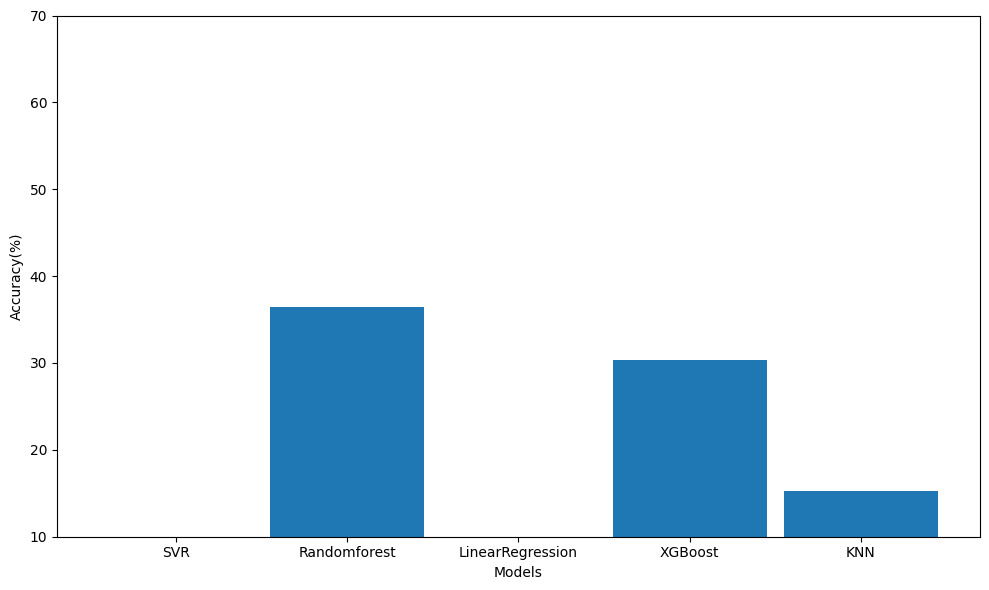

In [39]:
plt.figure(figsize=(10, 6))
plt.bar(models,accuracy,width=0.9)
plt.xlabel('Models')
plt.ylabel('Accuracy(%)')
plt.ylim(10, 70)
plt.tight_layout()
plt.show()